## Implementation of Neural Style Transfer using pretrained VGG16.

#### Importing Libraries

In [1]:
from __future__ import print_function
%tensorflow_version 1.x
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
# !pip install -U scipy==1.2.0
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from keras.applications.vgg16 import preprocess_input,decode_predictions
import IPython.display
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import functools
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow 1.x selected.
Eager execution: True


Using TensorFlow backend.


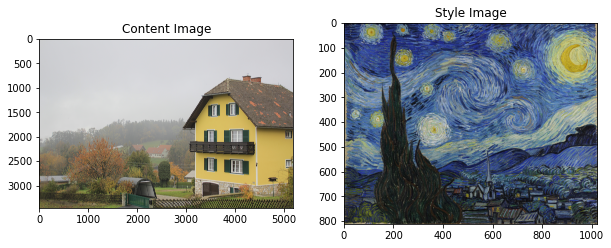

In [4]:
# Plotting Content and Style Image
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread('content.jpg'))
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread('style.jpg'))
plt.title('Style Image')
plt.show()

In [0]:
# Loading Preprocessing of Image

content_image=Image.open('content.jpg')
content_image=content_image.resize((512,512))
content_image = kp_image.img_to_array(content_image)
content_image = np.expand_dims(content_image, axis=0)
content_image = preprocess_input(content_image)

style_image= Image.open('style.jpg')
style_image=style_image.resize((512,512))
style_image = kp_image.img_to_array(style_image)
style_image = np.expand_dims(style_image, axis=0)
style_image = preprocess_input(style_image)


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1',  'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
# Set initial image
init_image = content_image

content_weight=1e3
style_weight=1000

loss_weights = (style_weight, content_weight)

num_rows = 4
num_cols = 5
num_iterations = 1000
display_interval = num_iterations/(num_rows*num_cols)

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

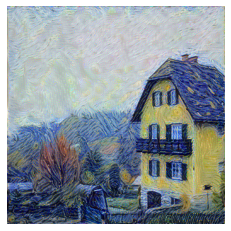

In [11]:
imgs = []
img_dir = '/content/drive/My Drive/data/images/'

# Load our model. We load pretrained VGG, trained on imagenet data
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
vgg.trainable = False
# Get output layers corresponding to style and content layers 
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs
# Build model 
model = models.Model(vgg.input, model_outputs)

for layer in model.layers:
  layer.trainable = False

# batch compute content and style features
style_outputs = model(style_image)
content_outputs = model(content_image)

# Get the style and content feature representations from our model  
style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

gram_style_features = []
for style_feature in style_features:
    channels = int(style_feature.shape[-1])
    a = tf.reshape(style_feature, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    gram_style_features.append(gram / tf.cast(n, tf.float32))


# Create our optimizer
opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

for i in range(num_iterations):
  with tf.GradientTape() as tape: 
    init_image = tf.Variable(init_image, dtype=tf.float32, trainable=True)
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
      height, width, channels = comb_style[0].get_shape().as_list()
      channels = int(comb_style.shape[-1])
      a = tf.reshape(comb_style, [-1, channels])
      n = tf.shape(a)[0]
      gram = tf.matmul(a, a, transpose_a=True)
    gram_style = gram / tf.cast(n, tf.float32)
  # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
      style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
      
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
      content_score += weight_per_content_layer* tf.reduce_mean(tf.square(comb_content[0] - target_content))

    
    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    all_loss = (loss, style_score, content_score)
  total_loss = all_loss[0]
  grads = tape.gradient(total_loss, init_image)

  opt.apply_gradients([(grads, init_image)])
  clipped = tf.clip_by_value(init_image, min_vals, max_vals)
  init_image.assign(clipped)

  if i % display_interval== 0:
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      x = plot_img.copy()
      if len(x.shape) == 4:
        x = np.squeeze(x, 0)
      assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
      if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
      # perform the inverse of the preprocessiing step
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      x = x[:, :, ::-1]

      x = np.clip(x, 0, 255).astype('uint8')
      plot_img = x
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      plt.imshow(plot_img)
      plt.axis('off')
      nameoffig = 'vgg16'+str(i)+'.jpg'
      plt.savefig(img_dir+ nameoffig)
  IPython.display.clear_output(wait=True)


#### Plotting all images stored at different intervals of iterations.

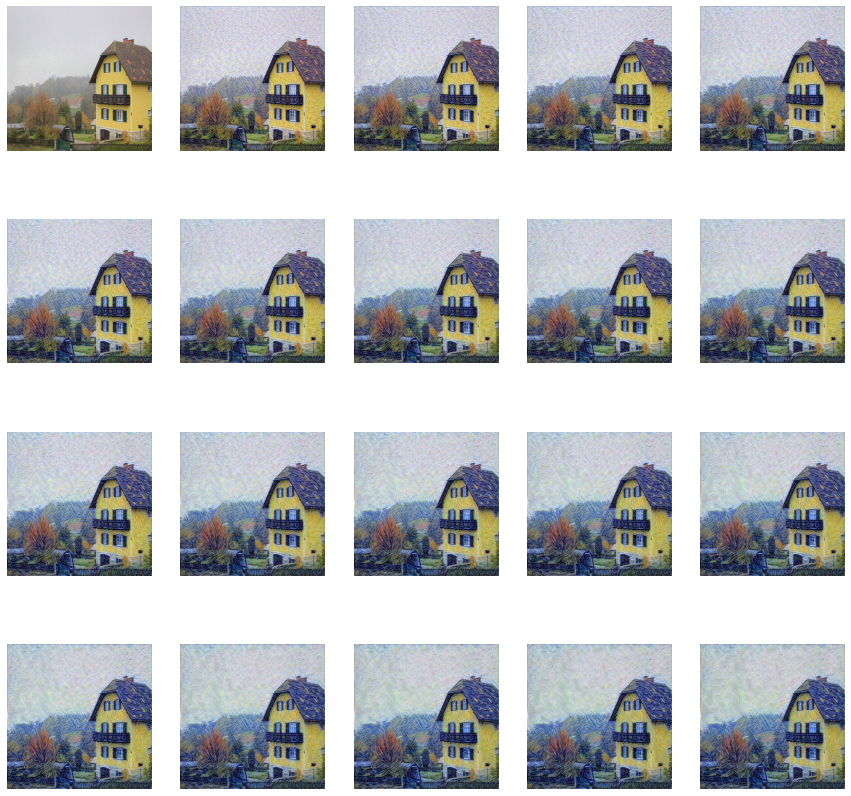

In [12]:
fig=plt.figure(figsize=(15, 15))
for i in range(num_rows*num_cols): 
    fig.add_subplot(num_rows, num_cols, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()